In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
from math import ceil


In [90]:
data=pd.read_csv("E:/Github projects/Ab testing/archive/ab_data.csv")

In [91]:
data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [92]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [93]:
pd.crosstab(data['group'],data['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [94]:
data.shape

(294478, 5)

In [95]:
#Finging more time engaement customers
session_counts=data['user_id'].value_counts(ascending=False)
multi_user=session_counts[session_counts>1].count()


In [96]:
print(f"there {multi_user} multiusers in the data")

there 3894 multiusers in the data


In [97]:
users_to_drop = session_counts[session_counts > 1].index

data = data[~data['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {data.shape[0]} entries')

The updated dataset now has 286690 entries


In [98]:
control_sample=data[data['group']=='control'].sample(n=4720, random_state=22)
treatment_sample=data[data['group']=='treatment'].sample(n=4720, random_state=22)


In [99]:
ab_test=pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)


In [100]:
ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


In [101]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [106]:
#fing std and std error and convesation_rates
conversion_rates=ab_test.groupby('group')['converted']

std_dev=lambda x:np.std(x, ddof=0)

std_error=lambda x:stats.sem(x, ddof=0)


In [107]:
conver_rates = conversion_rates.agg([np.mean, std_dev, std_error])
conver_rates.columns = ['conversion_rates', 'std_dev', 'std_error']
conver_rates.style.format('{:.3f}')

,conversion_rates,std_dev,std_error
group,,,
control,0.123,0.329,0.005
treatment,0.126,0.331,0.005


Text(0.5, 0, 'Group')

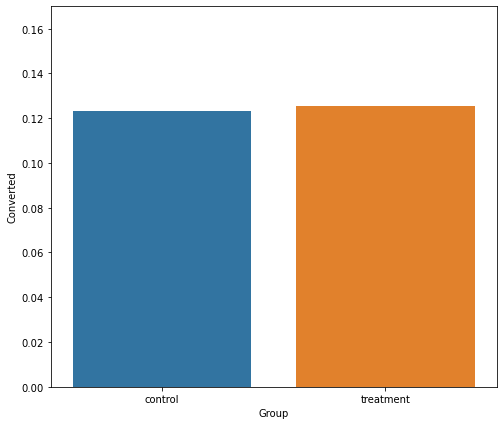

In [109]:
plt.figure(figsize=(8,7))
sns.barplot(x=ab_test['group'], y=ab_test['converted'],ci=False)
plt.ylim(0,0.17)
plt.ylabel("Converted")
plt.xlabel("Group")

In [115]:
from statsmodels.stats.proportion import proportions_ztest,proportion_confint

In [116]:
control_results=ab_test[ab_test['group']=='control']['converted']
treatment_results=ab_test[ab_test['group']=='treatment']['converted']


In [117]:
n_control_result=control_results.count()
n_treatment_results=treatment_results.count()
success=[control_results.sum(),treatment_results.sum()]
nobs=[n_control_result,n_treatment_results]

In [119]:
z_test, P_value=proportions_ztest(success,nobs=nobs)
(lower_control,lower_treatment),(upper_control, upper_treatement)=proportion_confint(success,nobs=nobs,alpha=0.05)
print(f'z statistic: {z_test:.2f}')
print(f'p-value: {P_value:.3f}')
print(f'ci 95% for control group: [{lower_control:.3f}, {upper_control:.3f}]')
print(f'ci 95% for treatment group: [{lower_treatment:.3f}, {upper_treatement:.3f}]')

z statistic: -0.34
p-value: 0.732
ci 95% for control group: [0.114, 0.133]
ci 95% for treatment group: [0.116, 0.135]


1.Since our p-value=0.732 is way above our α=0.05 threshold, we cannot reject the Null hypothesis Hₒ, which means that our new design did not perform significantly different (let alone better) than our old one 

2.Additionally, if we look at the confidence interval for the treatment group ([0.116, 0.135], or 11.6-13.5%) 

we notice that:

It includes our baseline value of 13% conversion rate
It does not include our target value of 15% (the 2% uplift we were aiming for)

What this means is that it is more likely that the true conversion rate of the new design is similar to our baseline, rather than the 15% target we had hoped for. This is further proof that our new design is not likely to be an improvement on our old design, and that unfortunately we are back to the drawing board